In [472]:
import pandas as pd
import numpy as np
from math import sqrt, ceil
from timeit import timeit, Timer

In [473]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.patches import ConnectionPatch
import matplotlib.animation as animation

rc('text', usetex=False)
plt.style.use('seaborn')
%matplotlib inline

legend_opts = {
    'fontsize':12,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}

In [474]:
%load_ext autoreload
%aimport utils
%autoreload 1
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [475]:
ci_multiplier = 2.262/np.sqrt(10)

# Load data

In [ ]:
male_scores = pd.read_csv('scores/trimmed_male.csv')
female_scores = pd.read_csv('scores/trimmed_female.csv')

In [ ]:
# Randomly choose 10 years for training set, and remaining 4 years for test set
# (which must include the last year 2018 for visualisation purpose)
all_years = range(2005, 2019)
years_before_last = range(2005, 2018)
year_seed = np.random.RandomState(seed=42)
train_years = sorted(list(year_seed.choice(years_before_last, size=10, replace=False)))
test_years = sorted([year for year in years_before_last if year not in train_years] + [2018, 2019])
train_years, test_years

In [9]:
all_season_scores = male_scores.loc[male_scores['event']!='WR']
all_world_scores = male_scores.loc[male_scores['event']=='WR']

In [10]:
# Split 10 years into train and validation set
random_state = np.random.RandomState(seed=42)
years1 = list(random_state.choice(train_years, size=5, replace=False))
years2 = [year for year in train_years if year not in years1]
years1, years2

([2016, 2006, 2012, 2005, 2014], [2007, 2009, 2010, 2013, 2017])

# Predict ranking in training set from different methods

## Male

In [410]:
beta1 = np.load('data/beta1.npy')
beta2 = np.load('data/beta2.npy')

Average

In [411]:
all_skater_scores = {}
for year in train_years:
    yearly_skater_scores = []
    season_scores, world_scores = get_yearly_scores(year, all_season_scores, all_world_scores)

    avg = AverageScore()
    avg.fit(season_scores)
    yearly_skater_scores.append(avg.skater_scores.reindex(world_scores.index).dropna())

    add = Linear()
    add.fit(season_scores)
    yearly_skater_scores.append(add.skater_scores.reindex(world_scores.index).dropna())

    mul = LogLinear()
    mul.fit(season_scores)
    yearly_skater_scores.append(mul.skater_scores.reindex(world_scores.index).dropna())

    _, _, skater_scores = train_multi(season_scores, n_factors=1, alpha=0.0005, n_iter=47)
    skater_scores = skater_scores.squeeze().reindex(world_scores.index).dropna()
    yearly_skater_scores.append(skater_scores)

    _, _, skater_scores = train_sequential_multi(season_scores, n_factors=4, alpha=0.0005, n_iter=35)
    skater_scores = skater_scores.reindex(world_scores.index).dropna()
    normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
    if year in years1:
        combined_scores = normed_skater_scores @ beta2
    else:
        combined_scores = normed_skater_scores @ beta1
    yearly_skater_scores.append(combined_scores)
    
    yearly_skater_scores = pd.concat(yearly_skater_scores, axis=1)
    yearly_skater_scores.columns = ['avg', 'add', 'mul', 'hyb', 'multi']
    yearly_skater_scores = (yearly_skater_scores - yearly_skater_scores.mean(axis=0)) / yearly_skater_scores.std(axis=0)
    all_skater_scores[year] = yearly_skater_scores

Alpha: 0.0005, Iter: 46, Last RMSE: 8.63, Delta RMSE: -0.0010916085
Factor: 0, Alpha: 0.0005, Iter: 35, Last RMSE: 8.662, Delta RMSE: -0.0080908948
Factor: 1, Alpha: 0.0005, Iter: 35, Last RMSE: 8.605, Delta RMSE: -0.0024092949
Factor: 2, Alpha: 0.0005, Iter: 35, Last RMSE: 8.519, Delta RMSE: -0.0036599525
Factor: 3, Alpha: 0.0005, Iter: 35, Last RMSE: 8.518, Delta RMSE: -0.000746563
Alpha: 0.0005, Iter: 46, Last RMSE: 7.96, Delta RMSE: -0.0009913676
Factor: 0, Alpha: 0.0005, Iter: 35, Last RMSE: 7.999, Delta RMSE: -0.007749829
Factor: 1, Alpha: 0.0005, Iter: 35, Last RMSE: 7.986, Delta RMSE: -0.0006821397
Factor: 2, Alpha: 0.0005, Iter: 35, Last RMSE: 7.957, Delta RMSE: -0.0011246966
Factor: 3, Alpha: 0.0005, Iter: 35, Last RMSE: 7.931, Delta RMSE: -0.0010131301
Alpha: 0.0005, Iter: 46, Last RMSE: 7.62, Delta RMSE: -0.0015000168
Factor: 0, Alpha: 0.0005, Iter: 35, Last RMSE: 7.679, Delta RMSE: -0.0133247831
Factor: 1, Alpha: 0.0005, Iter: 35, Last RMSE: 7.67, Delta RMSE: -0.0005301796

In [412]:
season_scores, world_scores = get_yearly_scores(2017, all_season_scores, all_world_scores)
world_ranking = list(world_scores.index)
rankings_2017 = []
skater_scores_2017 = all_skater_scores[2017]
for col_name, col in skater_scores_2017.iteritems():
    predicted_ranking = list(col.sort_values(ascending=False).index)
    calculate_kendall_tau(predicted_ranking, world_ranking)
    rankings_2017.append(predicted_ranking)
rankings_2017.append(list(world_scores.index))

There are 234 concordant_pairs out of 276 pairs
There are 239 concordant_pairs out of 276 pairs
There are 239 concordant_pairs out of 276 pairs
There are 241 concordant_pairs out of 276 pairs
There are 242 concordant_pairs out of 276 pairs


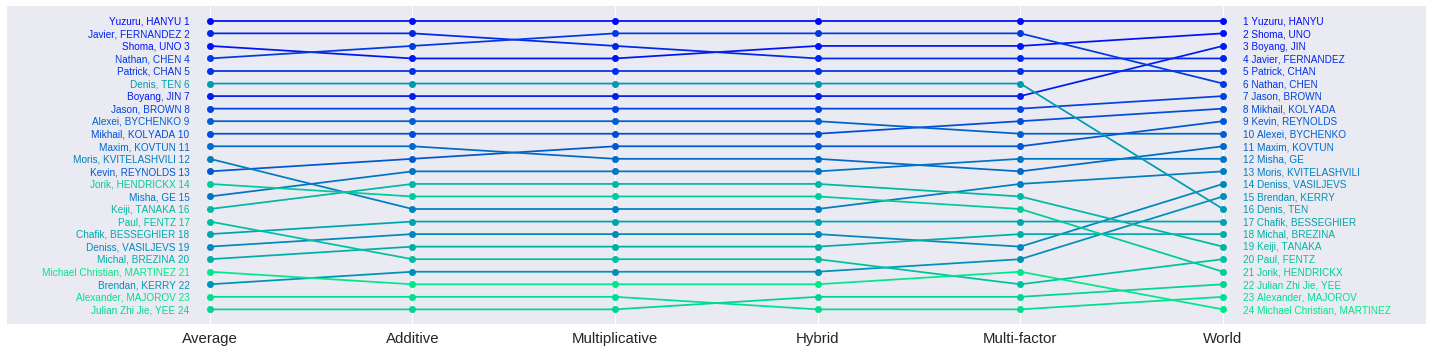

In [413]:
fig, ax = plt.subplots(figsize=(20, 5))
plot_multiple_rankings(fig, ax, rankings_2017, labels=['Average', 'Additive', 'Multiplicative', 'Hybrid', 'Multi-factor', 'World'],
                       filepath=None, xfontsize=15)

# Borda count

In [457]:
def build_borda_score(season_scores, world_scores, skater_scores):
    season_scores, world_scores = get_yearly_scores(year, all_season_scores, all_world_scores)
    world_ranking = list(world_scores.index)

    skater_scores = skater_scores.copy()
    # Find ranking from other skater scores (0=worse) and add them
    skater_scores['borda'] = skater_scores.values.argsort(axis=0).argsort(axis=0).sum(axis=1)
    # Sort skater rows by borda counts from lowes to highest, then average score for any ties in borda count
    skater_scores = skater_scores.sort_values(by=['borda', 'avg'])
    # Reset borda count to 0 to n_skater-1
    skater_scores['borda'] = range(len(skater_scores))

    # Reset rows back to world ranking order
    skater_scores = skater_scores.reindex(world_ranking).dropna()

    return skater_scores['borda']

In [468]:
dtaus_borda = {}

for year in train_years:
    print(year)
    season_scores, world_scores = get_yearly_scores(year, all_season_scores, all_world_scores)
    skater_scores = all_skater_scores[year]
    borda_scores = build_borda_score(season_scores, world_scores, skater_scores)
    
    # 22 skaters, 21th skater -> 22 - 1 - 21 = 0th skater
    borda_ranking, world_ranking = return_ranking(borda_scores, world_scores)
    borda_tau = calculate_kendall_tau(borda_ranking, world_ranking)
    dtaus_borda[year] = borda_tau - avg_taus[year]

2005
There are 173 concordant_pairs out of 210 pairs
2006
There are 205 concordant_pairs out of 253 pairs
2007
There are 224 concordant_pairs out of 276 pairs
2009
There are 222 concordant_pairs out of 276 pairs
2010
There are 198 concordant_pairs out of 231 pairs
2012
There are 202 concordant_pairs out of 253 pairs
2013
There are 213 concordant_pairs out of 253 pairs
2014
There are 190 concordant_pairs out of 210 pairs
2016
There are 233 concordant_pairs out of 276 pairs
2017
There are 240 concordant_pairs out of 276 pairs


In [469]:
np.mean(list(dtaus_borda.values()))

0.0026708074534161574

In [470]:
np.std(list(dtaus_borda.values())) * ci_multiplier

0.026224239759557007

# Logistic regression

## Score difference

In [442]:
# Get yearly Kendall's tau from average model for comparison
avg = AverageScore()
avg_result = avg.evaluate_over_years(all_years, all_season_scores, all_world_scores).set_index('year')
avg_taus = avg_result['tau'].to_dict()

In [443]:
X1 = {}
X2 = {}
for year, skater_scores in all_skater_scores.items():
    X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(skater_scores.values, 2)))
    if year in years1:
        X1[year] = X
    else:
        X2[year] = X
        
stacked_X1 = np.concatenate(list(X1.values()))
stacked_X2 = np.concatenate(list(X2.values()))

In [444]:
log_gen1 = log_gradient_ascent_log(stacked_X1, alpha=0.0005, n_iter=2000, log_every=1, verbose=True)
log_gen2 = log_gradient_ascent_log(stacked_X2, alpha=0.0005, n_iter=2000, log_every=1, verbose=True)

avg_dtaus_train = []
avg_dtaus_val = []
log_iters = []
betas1 = []
betas2 = []

# Train logistic regression model on each fold and return logged values at specified iterations
for log_log1, log_log2 in zip(log_gen1, log_gen2):
    log_iter = log_log1[0]
    beta1 = log_log1[1]
    beta2 = log_log2[1]
    
    betas1.append(beta1)
    betas2.append(beta2)

    # Model coefficients at specified iterations are used to evaluate
    # improvement in Kendall's tau on both folds
    dtaus_train = {}
    dtaus_val = {}
    for year in years1:
        dtaus_train[year] = get_tau_from_X_beta(X1[year], beta1) - avg_taus[year]
        dtaus_val[year] = get_tau_from_X_beta(X1[year], beta2) - avg_taus[year]
    for year in years2:
        dtaus_train[year] = get_tau_from_X_beta(X2[year], beta2) - avg_taus[year]
        dtaus_val[year] = get_tau_from_X_beta(X2[year], beta1) - avg_taus[year]

    # Take average improvement in Kendall's tau for each combination of
    # stopping iterations of multi-factor and logistic regression model
    log_iters.append(log_iter)
    avg_dtaus_train.append(np.mean(list(dtaus_train.values())))
    avg_dtaus_val.append(np.mean(list(dtaus_val.values())))

Alpha: 0.0005, Iter: 1999, Last LL: -0.34, Delta LL: 8e-08


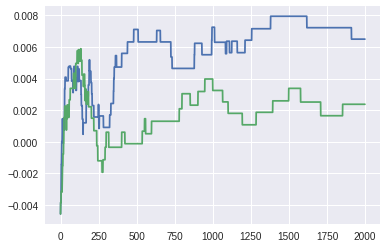

In [445]:
plt.plot(avg_dtaus_train)
plt.plot(avg_dtaus_val)
# plt.xlim(0, 1000)

In [390]:
beta1max = betas1[np.argmax(avg_dtaus_val)]
beta2max = betas2[np.argmax(avg_dtaus_val)]

In [448]:
season_scores, world_scores = get_yearly_scores(2017, all_season_scores, all_world_scores)
world_ranking = list(world_scores.index)
rankings_2017 = []
skater_scores_2017 = all_skater_scores[2017].copy()
skater_scores_2017['log'] = skater_scores_2017 @ beta1max
for col_name, col in skater_scores_2017.iteritems():
    predicted_ranking = list(col.sort_values(ascending=False).index)
    calculate_kendall_tau(predicted_ranking, world_ranking)
    rankings_2017.append(predicted_ranking)
rankings_2017.append(rankings_borda[2017])
rankings_2017.append(list(world_scores.index))

There are 234 concordant_pairs out of 276 pairs
There are 239 concordant_pairs out of 276 pairs
There are 239 concordant_pairs out of 276 pairs
There are 241 concordant_pairs out of 276 pairs
There are 242 concordant_pairs out of 276 pairs
There are 243 concordant_pairs out of 276 pairs


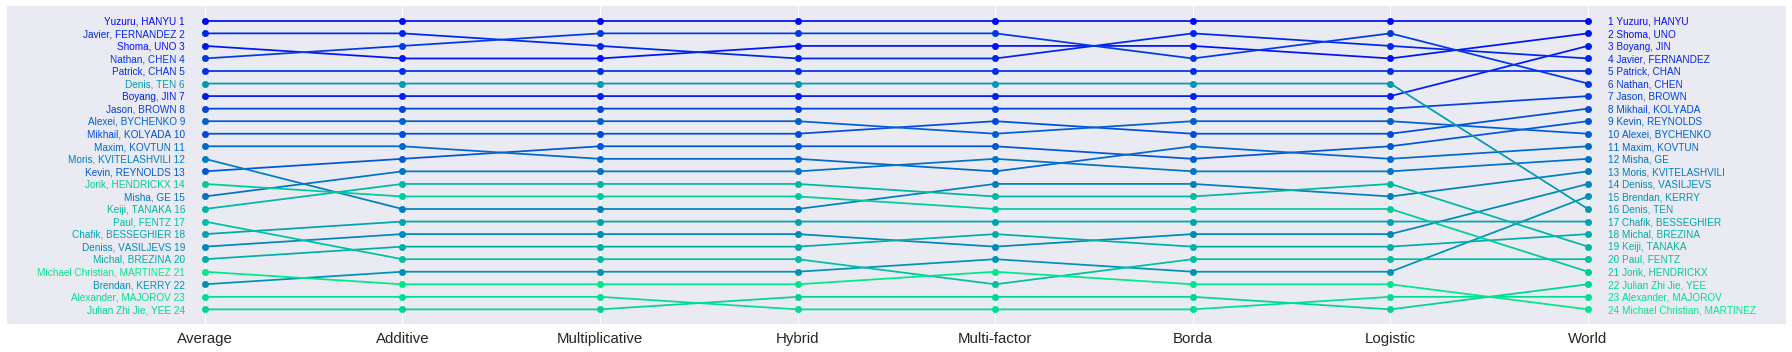

In [451]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_multiple_rankings(fig, ax, rankings_2017, labels=['Average', 'Additive', 'Multiplicative', 'Hybrid', 'Multi-factor', 
                                                       'Borda', 'Logistic', 'World'],
                       filepath=None, xfontsize=15)

## Rank difference

In [361]:
X1 = {}
X2 = {}
for year, skater_scores in all_skater_scores.items():
    skater_ranks = skater_scores.values.argsort(axis=0).argsort(axis=0)
    X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(skater_ranks, 2)))
    if year in years1:
        X1[year] = X
    else:
        X2[year] = X
        
stacked_X1 = np.concatenate(list(X1.values()))
stacked_X2 = np.concatenate(list(X2.values()))

In [377]:
log_gen1 = log_gradient_ascent_log(stacked_X1, alpha=0.0005, n_iter=2000, log_every=1, verbose=True)
log_gen2 = log_gradient_ascent_log(stacked_X2, alpha=0.0005, n_iter=2000, log_every=1, verbose=True)

avg_dtaus_train = []
avg_dtaus_val = []
log_iters = []

# Train logistic regression model on each fold and return logged values at specified iterations
for log_log1, log_log2 in zip(log_gen1, log_gen2):
    log_iter = log_log1[0]
    beta1 = log_log1[1]
    beta2 = log_log2[1]

    # Model coefficients at specified iterations are used to evaluate
    # improvement in Kendall's tau on both folds
    dtaus_train = {}
    dtaus_val = {}
    for year in years1:
        dtaus_train[year] = get_tau_from_X_beta(X1[year], beta1) - avg_taus[year]
        dtaus_val[year] = get_tau_from_X_beta(X1[year], beta2) - avg_taus[year]
    for year in years2:
        dtaus_train[year] = get_tau_from_X_beta(X2[year], beta2) - avg_taus[year]
        dtaus_val[year] = get_tau_from_X_beta(X2[year], beta1) - avg_taus[year]

    # Take average improvement in Kendall's tau for each combination of
    # stopping iterations of multi-factor and logistic regression model
    log_iters.append(log_iter)
    avg_dtaus_train.append(np.mean(list(dtaus_train.values())))
    avg_dtaus_val.append(np.mean(list(dtaus_val.values())))

Alpha: 0.0005, Iter: 1999, Last LL: -2.79, Delta LL: 1.2266428713


For some reason very unstable performance

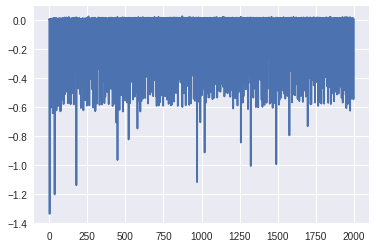

In [378]:
plt.plot(avg_dtaus_train)
# plt.plot(avg_dtaus_val)
# plt.xlim(0, 1000)

# Benchmark for test